# Product Design Challenge

Tools for the review of a four bar linkage.

In [1]:
import scipy as sp
from scipy.linalg import solve

import pandas as pd

from matplotlib import pyplot as plt

## Link Geometry

Solve for the angles between the links and the force.  Assuming theta and phi are known currently.  Eventually solve for phi as a function of theta. The angle phi will not vary linearly with theta, but it will be a good first estimate.



In [2]:
n = 100        # Number of steps to calculate

# Known
AB = 23.44     # [mm] Link AB length
BC = 6         # [mm] Link BC Length
CD = 15.5      # [mm] Link CD Length
AD = 14        # [mm] Link AD Length

theta = sp.linspace(86, 14, n) * 2*sp.pi/360  # [radians] 
phi = sp.linspace(33, 6, n) * 2*sp.pi/360     # [radians]

# Solving for partial lengths of the system to determine the remaining angles
a = AD * sp.sin(phi)
b = AD * sp.cos(phi)
c = AB - b
d = BC * sp.sin(theta)
e = BC * sp.cos(theta)
f = c + e
g = a - d

psi = sp.arctan(g/f)
xi = (sp.pi/2) - psi

T = 0.38 * ((sp.pi/2) - theta) * 360/(2*sp.pi)       # [mm N] Torque on joint A per degree of rotation

## Linear Equations

Set up the series of linear equations to make it easy to populate the matrix.

For n number of links there are 3 * (n - 1) equations and unknowns.  If we consider friction in the joints there are and additional n equations and unknowns.

For this system we are going to assume the spring force is known and the force required to oppose it is required.  This will let us know the force required to close the system at all angles.

In [3]:
# Index
index = ['LinkAB_F_x', 'LinkAB_F_y', 'LinkAB_M_B', 'LinkBC_F_x', 'LinkBC_F_y', 'LinkBC_M_C', 
        'LinkCD_F_x', 'LinkCD_F_y', 'LinkCD_M_D']

# Variables to solve for
var = ['F_Ax', 'F_Ay', 'F_Bx', 'F_By', 'F_Cx', 'F_Cy', 'F_Dx', 'F_Dy', 'F']


## Dataframe of the variables [x], as a function of theta and phi
x_theta = pd.DataFrame(sp.zeros((len(var), n)), index = var, columns = range(n))


# Solve the Linear Equations for each step
for i in range(n):
    
    #i = 0
    ## Dataframe of equations [A]
    eqn = pd.DataFrame(sp.zeros((len(index), len(index))), index = index, columns = var)
    
    # Link AB
    eqn.loc[['LinkAB_F_x'],['F_Ax']] = 1
    eqn.loc[['LinkAB_F_x'],['F_Bx']] = 1
    
    eqn.loc[['LinkAB_F_y'],['F_Ay']] = 1
    eqn.loc[['LinkAB_F_y'],['F_By']] = 1
    
    eqn.loc[['LinkAB_M_B'],['F_Ay']] = AB * sp.cos(theta[i])
    eqn.loc[['LinkAB_M_B'],['F_Ax']] = -AB * sp.sin(theta[i])
    
    # Link BC
    eqn.loc[['LinkBC_F_x'],['F_Bx']] = -1
    eqn.loc[['LinkBC_F_x'],['F_Cx']] = 1
    eqn.loc[['LinkBC_F_x'],['F']] = sp.cos(xi[i])
    
    eqn.loc[['LinkBC_F_y'],['F_By']] = -1
    eqn.loc[['LinkBC_F_y'],['F_Cy']] = 1
    eqn.loc[['LinkBC_F_y'],['F']] = sp.sin(xi[i])
    
    eqn.loc[['LinkBC_M_C'],['F_By']] = BC * sp.sin(psi[i])
    eqn.loc[['LinkBC_M_C'],['F_Bx']] = BC * sp.cos(psi[i])
    
    # Link CD
    eqn.loc[['LinkCD_F_x'],['F_Cx']] = -1
    eqn.loc[['LinkCD_F_x'],['F_Dx']] = 1
    
    eqn.loc[['LinkCD_F_y'],['F_Cy']] = -1
    eqn.loc[['LinkCD_F_y'],['F_Dy']] = 1
    
    eqn.loc[['LinkCD_M_D'],['F_Cy']] = CD * sp.sin(phi[i])
    eqn.loc[['LinkCD_M_D'],['F_Cx']] = -CD * sp.cos(phi[i])
    
    ## Dataframe of solutions [b]
    sol = pd.DataFrame(sp.zeros((len(index), 1)), index = index, columns = ['b'])
    
    # Link AB
    sol.loc[['LinkAB_M_B']] = -T[i]
    
    ## Dataframe of the variables [x]
    x = pd.DataFrame(solve(eqn,sol), index = var, columns = ['x'])
    
    x_theta.iloc[:,i]=x

## Plot the Data
Review the plots to ensure everything is moving as expected.

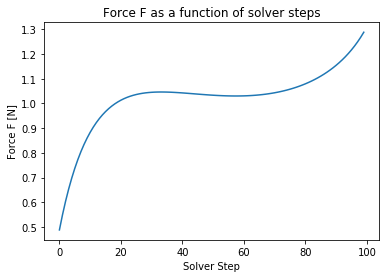

In [4]:
# Force F as a function of solver step

plt.plot(x_theta.loc['F'])
plt.ylabel('Force F [N]')
plt.xlabel('Solver Step')
plt.title('Force F as a function of solver steps')
plt.show()

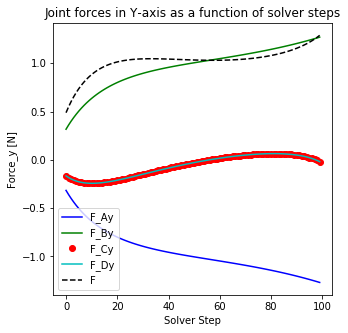

In [5]:
# Solve for the forces in the y axis

plt.figure(figsize=(5,5))
plt.plot((x_theta.loc['F_Ay']), 'b')
plt.plot((x_theta.loc['F_By']), 'g')
plt.plot((x_theta.loc['F_Cy']), 'or')
plt.plot((x_theta.loc['F_Dy']), '-c')
plt.plot(x_theta.loc['F'], '--k')
plt.legend(['F_Ay', 'F_By', 'F_Cy', 'F_Dy', 'F'], loc='best')
plt.ylabel('Force_y [N]')
plt.xlabel('Solver Step')
plt.title('Joint forces in Y-axis as a function of solver steps')
plt.show()

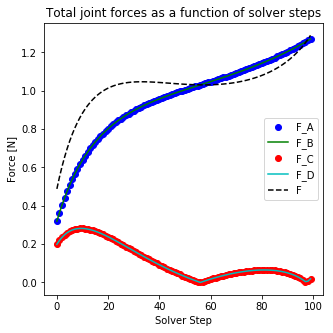

In [6]:
# Solve for the total force at the joints
plt.figure(figsize=(5,5))
plt.plot(sp.sqrt((x_theta.loc['F_Ax'])**2+(x_theta.loc['F_Ay'])**2), 'ob')
plt.plot(sp.sqrt((x_theta.loc['F_Bx'])**2+(x_theta.loc['F_By'])**2), '-g')
plt.plot(sp.sqrt((x_theta.loc['F_Cx'])**2+(x_theta.loc['F_Cy'])**2), 'or')
plt.plot(sp.sqrt((x_theta.loc['F_Dx'])**2+(x_theta.loc['F_Dy'])**2), '-c')
plt.plot(x_theta.loc['F'], '--k')
plt.legend(['F_A', 'F_B', 'F_C', 'F_D', 'F'], loc='best')
plt.ylabel('Force [N]')
plt.xlabel('Solver Step')
plt.title('Total joint forces as a function of solver steps')
plt.savefig('Total Joint Forces')
plt.show()



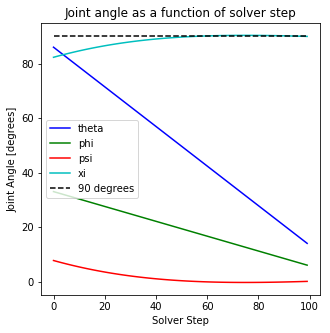

In [7]:
# Illustrate the variation of the calculated angles

plt.figure(figsize=(5,5))
plt.plot((theta)*360/(2*sp.pi), 'b')
plt.plot((phi)*360/(2*sp.pi), 'g')
plt.plot((psi)*360/(2*sp.pi), 'r')
plt.plot((xi)*360/(2*sp.pi), 'c')
plt.plot([min(range(n)), max(range(n))], [90,90], '--k')
plt.legend(['theta', 'phi', 'psi', 'xi', '90 degrees'], loc='best')
plt.ylabel('Joint Angle [degrees]')
plt.xlabel('Solver Step')
plt.title('Joint angle as a function of solver step')
plt.savefig('Joint Angles')
plt.show()

## Adding Friction

Ideally friction would be included in the linear equations above or calculated using superposition, but in the interest of saving time I am assuming the friction will not significantly affect the forces at the joints.  This lets me calculate the friction as a constant as a function of the geometry.  The following is the same equations as the above with the friction forces added to the solution matrix b.


In [23]:
# Known
mu = 0.05

F_A = sp.sqrt((x_theta.loc['F_Ax'])**2+(x_theta.loc['F_Ay'])**2)
F_B = sp.sqrt((x_theta.loc['F_Bx'])**2+(x_theta.loc['F_By'])**2)
F_C = sp.sqrt((x_theta.loc['F_Cx'])**2+(x_theta.loc['F_Cy'])**2)
F_D = sp.sqrt((x_theta.loc['F_Dx'])**2+(x_theta.loc['F_Dy'])**2)

R_A = mu*F_A
R_B = mu*F_B
R_C = mu*F_C
R_D = mu*F_D

## Dataframe of the variables [x], as a function of theta and phi
x_r = pd.DataFrame(sp.zeros((len(var), n)), index = var, columns = range(n))


# Solve the Linear Equations for each step
for i in range(n):
    
    #i = 0
    ## Dataframe of equations [A]
    eqn = pd.DataFrame(sp.zeros((len(index), len(index))), index = index, columns = var)
    
    # Link AB
    eqn.loc[['LinkAB_F_x'],['F_Ax']] = 1
    eqn.loc[['LinkAB_F_x'],['F_Bx']] = 1
    
    eqn.loc[['LinkAB_F_y'],['F_Ay']] = 1
    eqn.loc[['LinkAB_F_y'],['F_By']] = 1
    
    eqn.loc[['LinkAB_M_B'],['F_Ay']] = AB * sp.cos(theta[i])
    eqn.loc[['LinkAB_M_B'],['F_Ax']] = -AB * sp.sin(theta[i])
    
    # Link BC
    eqn.loc[['LinkBC_F_x'],['F_Bx']] = -1
    eqn.loc[['LinkBC_F_x'],['F_Cx']] = 1
    eqn.loc[['LinkBC_F_x'],['F']] = sp.cos(xi[i])
    
    eqn.loc[['LinkBC_F_y'],['F_By']] = -1
    eqn.loc[['LinkBC_F_y'],['F_Cy']] = 1
    eqn.loc[['LinkBC_F_y'],['F']] = sp.sin(xi[i])
    
    eqn.loc[['LinkBC_M_C'],['F_By']] = BC * sp.sin(psi[i])
    eqn.loc[['LinkBC_M_C'],['F_Bx']] = BC * sp.cos(psi[i])
    
    # Link CD
    eqn.loc[['LinkCD_F_x'],['F_Cx']] = -1
    eqn.loc[['LinkCD_F_x'],['F_Dx']] = 1
    
    eqn.loc[['LinkCD_F_y'],['F_Cy']] = -1
    eqn.loc[['LinkCD_F_y'],['F_Dy']] = 1
    
    eqn.loc[['LinkCD_M_D'],['F_Cy']] = CD * sp.sin(phi[i])
    eqn.loc[['LinkCD_M_D'],['F_Cx']] = -CD * sp.cos(phi[i])
    
    ## Dataframe of solutions [b]
    sol = pd.DataFrame(sp.zeros((len(index), 1)), index = index, columns = ['b'])
    
    # Link AB
    sol.loc[['LinkAB_M_B']] = -T[i] - R_A[i] - R_B[i]
    
    # Link BC
    sol.loc[['LinkBC_M_C']] = -R_C[i] - R_B[i]
    
    # Link CD
    sol.loc[['LinkCD_M_D']] = -R_C[i] - R_D[i]
    
    ## Dataframe of the variables [x]
    x = pd.DataFrame(solve(eqn,sol), index = var, columns = ['x'])
    
    x_r.iloc[:,i]=x

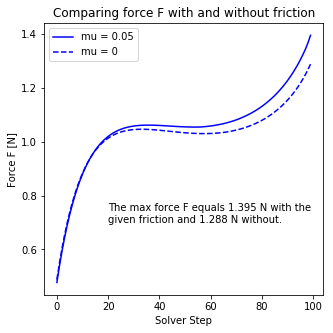

In [24]:
# Compare the Force F with friction and without

plt.figure(figsize=(5,5))
plt.plot(x_r.loc['F'], '-b')
plt.plot(x_theta.loc['F'], '--b')
plt.legend(['mu = %.2f' %mu, 'mu = 0'], loc='best')
plt.ylabel('Force F [N]')
plt.xlabel('Solver Step')
plt.title('Comparing force F with and without friction')
plt.text(20, .7, 'The max force F equals %.3f N with the \ngiven friction and %.3f N without.' 
      %(max(x_r.loc['F']), max(x_theta.loc['F'])))
plt.savefig('F with and without friction')
plt.show()


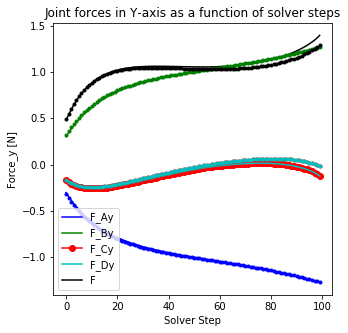

In [17]:
# Compare all forces with and without friction

plt.figure(figsize=(5,5))
plt.plot((x_r.loc['F_Ay']), '-b')
plt.plot((x_r.loc['F_By']), '-g')
plt.plot((x_r.loc['F_Cy']), '-or')
plt.plot((x_r.loc['F_Dy']), '-c')
plt.plot(x_r.loc['F'], '-k')

plt.plot((x_theta.loc['F_Ay']), '.b')
plt.plot((x_theta.loc['F_By']), '.g')
plt.plot((x_theta.loc['F_Cy']), '.r')
plt.plot((x_theta.loc['F_Dy']), '.c')
plt.plot(x_theta.loc['F'], '.k')
plt.legend(['F_Ay', 'F_By', 'F_Cy', 'F_Dy', 'F'], loc='best')
plt.ylabel('Force_y [N]')
plt.xlabel('Solver Step')
plt.title('Joint forces in Y-axis as a function of solver steps')
plt.show()

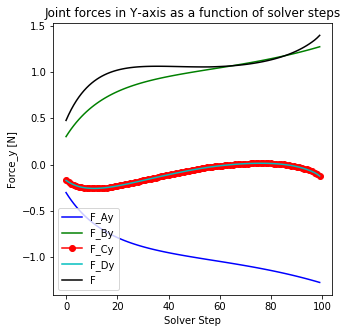

In [19]:
# Compare all forces with friction

plt.figure(figsize=(5,5))
plt.plot((x_r.loc['F_Ay']), '-b')
plt.plot((x_r.loc['F_By']), '-g')
plt.plot((x_r.loc['F_Cy']), '-or')
plt.plot((x_r.loc['F_Dy']), '-c')
plt.plot(x_r.loc['F'], '-k')
plt.legend(['F_Ay', 'F_By', 'F_Cy', 'F_Dy', 'F'], loc='best')
plt.ylabel('Force_y [N]')
plt.xlabel('Solver Step')
plt.title('Joint forces in Y-axis as a function of solver steps')
plt.savefig('Joint forces with friction')
plt.show()